Consider again the empirical risk minimization:
\begin{equation}
\min_{w \in \mathbb{R}^d} \frac{1}{n} \sum\limits_{i=1}^n \ell (g(w, x_i), y_i) + \frac{\lambda}{2} \| w\|^2_2,
\end{equation}
where $\ell: \mathbb{R} \times \mathbb{R} \to \mathbb{R}$ is a loss function, $g : \mathbb{R}^d \times \mathbb{R}^x \to \mathbb{R}$ is a model, $w$ are parameters of the model, $\{x_i, y_i\}_{i=1}^n$ is data of objects $x_i \in \mathbb{R}^x$ and labels $y_i \in \mathbb{R}$.

We use the linear model $g(w, x) = w^T x$ and the logistic/sigmoid loss function: $\ell(z,y) = \ln (1 + \exp(-yz))$

This problem can be rewritten as follows:
\begin{equation}
\min_{w \in \mathbb{R}^d} f(w) := \frac{1}{s} \sum\limits_{j=1}^s f_j(w) := \frac{1}{s} \sum\limits_{j=1}^s \left[\frac{1}{b} \sum\limits_{i=1}^b l (g(w, x_{(j-1)b + i}), y_{(j-1)b + i}) + \frac{\lambda}{2} \| w\|^2_2\right],
\end{equation}
where $b$ is the local data size, $s$ is the number of devices, and $b s = n$ is the total sample size.

The gradient of $f_j$:
$$
\nabla f_j(w) = \frac{1}{b} \sum_{i=1}^b \frac{-y_{(j-1)b + i} x_{(j-1)b + i}}{1 + \exp(y_{(j-1)b + i} w^Tx_{(j-1)b + i})} + \lambda w.
$$
The Lipschitz constant of the gradient $\nabla f_j$ can be estimated as $L_j = \frac{1}{4b} \sum\limits_{i=1}^b \| x_{(j-1)b + i} \|^2_2 + \lambda$.



In [ ]:
dataset = "mushrooms.txt"
#the file must be in the same directory as notebook.

In [ ]:
from sklearn.datasets import load_svmlight_file
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]

In [ ]:
import jax.numpy as jnp
import jax
import numpy as np
import time
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from itertools import accumulate

Let us change the vector $y$ so that $y_i$ takes values $-1$ and $1$.


In [ ]:
y = 2 * y - 3

Let us divide the data into two parts: training and test.

In [ ]:
X = X[:2000, :]
y = y[:2000]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
d = X_train.shape[1]

In [ ]:
def estimate_L(X):
    n = X.shape[0]
    return np.trace(X @ X.T)/4/n

In [ ]:
L = estimate_L(X_train)
mu = L/100

conv = L/ mu

In [ ]:
def f_value(w, X, y):
   return jnp.mean(jnp.log(1 + jnp.exp(- y * (X@w)))) + mu/2 * jnp.dot(w,w)

f_grad = jax.grad(f_value)




In [ ]:
def predict(X_test, w):
    return jnp.where(X_test@w >= 0, 1, -1)

def accuracy(y_test, y_pred):
    return  jnp.mean(y_test == y_pred)

In [ ]:
class UniDataloader:
  def __init__(self, X,y, s):
      self.X, self.y = shuffle(X, y)

      self.b = len(self.y)//s
      self.s  = s
      self.n = len(self.y)
  def __len__(self):
      return self.s
  def get_batch(self, j):
      j = j % self.s
      return self.X[j*self.b : min((j+1) * self.b, self.n) , : ], self.y[j*self.b : min((j+1) * self.b, self.n) ]


In [ ]:
class PropDataLoader:
  def __init__(self, X,y, probs ):
      self.X, self.y = shuffle(X, y)
      self.s = len(probs)

      self.pos_X = self.X[self.y == 1]
      self.pos_y = self.y[self.y == 1]

      self.neg_X = self.X[self.y == -1]
      self.neg_y = self.y[self.y == -1]

      i = 0
      j = 0
      min_len = min(len(self.neg_y), len(self.pos_y))
      step = min_len // self.s


      self.batches = dict()

      for k, p in enumerate(probs):
        if (p >= 0.5):
          i_next = min(i + step, min_len)
          j_next = min(j + int(step*(1-p)/p), min_len)
        else:
          j_next = min( j+ step, min_len)
          i_next = min(i + int(step*p/(1-p)), min_len)


        batch_X = self.pos_X[i : i_next, :]
        batch_y = self.pos_y[i : i_next ]

        batch_X = np.vstack((batch_X, self.neg_X[j : j_next, :]))
        batch_y = np.hstack((batch_y, self.neg_y[j : j_next]))


        i = i_next
        j = j_next
        self.batches[k] = (batch_X, batch_y)

  def __len__(self):
      return self.s
  def get_batch(self, j):
      j = j % self.s
      return self.batches[j]


In [ ]:
s = 3
prop_loader = PropDataLoader(X, y, probs = np.linspace(0,1,3))
uni_loader = UniDataloader(X, y, s)

In [ ]:
def Full(W, loader, lambd = 1):
    f = 0
    w_avr = jnp.mean(W, axis = 0)
    n = len(loader)
    for i  in range(n):
        X_m, y_m =  loader.get_batch(i)
        f += f_value(W[i], X_m, y_m)
        f += lambd/2/n*jnp.dot(W[i] - w_avr, W[i] - w_avr)
    return f

Full_grad  =jax.grad(Full)

Everywhere below we need to estimate $L$ smoothness constant that will be appropriate for all functions $f_m$. We can simply take maximum of all $L_m$ across all batches.

In [ ]:
def estimate_L_for_loader(loader):
    L = 0
    for i in range(len(loader)):
        X_b, y_b = loader.get_batch(i)
        L = max(L, estimate_L(X_b))
    return L



# Methods

In [ ]:
def Katusha( func, X , labels, lambd, avr_w,   K = 1000, tol = 10**-4):
    errors = []
    times = []
    m = 10
    loader = UniDataloader(X, labels, m)

    L = estimate_L(X)

    tau2 = 1/2
    tau1 = min(np.sqrt(m * lambd/ 3/ L), 0.5)
    step = 1/3/tau1/L

    snap = avr_w
    y = avr_w
    z = avr_w

    f =  lambda w, Mat, vec: func(w, Mat, vec) + lambd/2*jnp.dot(w - avr_w, w - avr_w)
    grad_f = jax.grad(f)
    R_f_0 = jnp.linalg.norm(grad_f(snap, X, labels))

    for k in range(K):
        y_s = []
        mu = grad_f(snap, X, labels)
        for j in range(m):
            x  = tau1*z + tau2*snap + (1 - tau1 -tau2)*y
            i = random.randint(0, X.shape[0] - 1)
            X_b, labels_b = loader.get_batch(j)
            nabla = mu + grad_f(x, X_b, labels_b) - grad_f(snap, X_b, labels_b)
            z_next = z + avr_w - step*nabla
            y = x + tau1*(z_next  - z)
            y_s.append(y)
            z_next = z - step * nabla

        snap = sum([ (1 + step * lambd)**j * y_s[j] for j in range(m)])
        snap /= sum([ (1 + step * lambd)**j  for j in range(m)])

        error = jnp.linalg.norm(grad_f(snap, X, labels))/R_f_0

        if error <= tol:

              break

    return snap

In [ ]:
def NAG( func, X, labels, lambd, avr_w,  mu, K = 1000, eps = 10**-4):
    errors = []
    times = []

    L = estimate_L(X)
    f =  lambda w: func(w, X, labels) + lambd/2*jnp.dot(w - avr_w, w - avr_w)
    nabla_f = jax.grad(f)


    x_min = avr_w
    f_min = f(avr_w)
    x_prev = avr_w
    x_k = avr_w

    total_time = 0

    R_f_0 = jnp.linalg.norm(nabla_f(avr_w))



    for k in range(K):
        start = time.time()
        z_k = x_k + (np.sqrt(L) - np.sqrt(mu))/(np.sqrt(L) + np.sqrt(mu))*(x_k - x_prev)
        x_k_1 = z_k - nabla_f(z_k)/L


        x_prev = x_k
        x_k = x_k_1
        f_x_k = f(x_k)
        if(f_min > f_x_k):
            f_min = f_x_k
            x_min = x_k

        error  = jnp.linalg.norm(nabla_f(x_k))/ R_f_0


        end = time.time()
        total_time += end - start
        times.append(total_time)
        errors.append(error)

        if error <= eps:
          break

    return x_min

In [ ]:
def APGD(func, Full, loader, w_0, prox, inner_T, lambd, L, mu, tol = 1e-4,  max_iter = 100, X_test = None, y_test = None ):
    s = len(loader)
    cur_ym = [w_0]*s
    cur_xm = [w_0]*s


    accs = []
    errors = []

    grad_func = jax.grad(func)
    grad_Full  =jax.grad(Full)
    norm_error = jnp.linalg.norm(grad_Full(jnp.array(cur_ym), loader, lambd))
    for i in tqdm(range(max_iter)):

        if prox is not None:
            avr_w = sum(cur_ym)/s
            for m  in range(s):
                X_m, labels_m = loader.get_batch(m)

                prox_res = prox(func, X_m, labels_m, lambd, avr_w,  K = inner_T[i], mu =mu )
                cur_ym[m] = prox_res + (np.sqrt(lambd) - np.sqrt(mu))/(np.sqrt(lambd) + np.sqrt(mu))  * (prox_res - cur_xm[m])
                cur_xm[m] = prox_res
        else:
            for m in range(s):
                X_m, labels_m = loader.get_batch(m)
                cur_ym[m] -= 1/L*grad_func(cur_ym[m], X_m, labels_m)
            avr_w = sum(cur_ym)/s
            for m in range(s):
                prox_res = (L * cur_ym[m] + lambd*avr_w)/(L+lambd)
                cur_ym[m] = prox_res + (np.sqrt(L) - np.sqrt(mu))/(np.sqrt(L) + np.sqrt(mu))  * (prox_res - cur_xm[m] )
                cur_xm[m] = prox_res



        error = jnp.linalg.norm(grad_Full(jnp.array(cur_ym), loader, lambd))/norm_error
        errors.append(error)
        if error < tol:
            break

        if X_test is not None:
                avr_w = sum(cur_ym)/s
                y_pred = predict(X_test, avr_w)
                accs.append(accuracy(y_test, y_pred).item())

    return avr_w, errors, accs


# $\lambda < L$

In [ ]:
key = jax.random.PRNGKey(42)
w_0 = jax.random.normal(key, [d])
lambd = 5*mu
m = len(uni_loader)
inner_NAG = [int(np.sqrt(mu*(L + lambd)/lambd/(mu + lambd))*(1 + k)) for k in range(1, 150)]
inner_const = [10  for k in range(1, 150)]

In [ ]:
w_NAG, errors_NAG, accs_NAG = APGD(f_value, Full, uni_loader, w_0, NAG, inner_NAG, lambd = lambd, L = L, mu = mu, tol = 1e-4,  max_iter = 50, X_test = X_test, y_test = y_test )

100%|██████████| 50/50 [04:45<00:00,  5.70s/it]


In [ ]:
w_0 = jax.random.normal(key, [d])
w_1, errors_1, accs_1= APGD(f_value, Full, uni_loader, w_0, None, None, lambd = lambd, L = L, mu = mu, tol = 1e-4,  max_iter = 50, X_test = X_test, y_test = y_test )

100%|██████████| 50/50 [00:05<00:00,  9.51it/s]


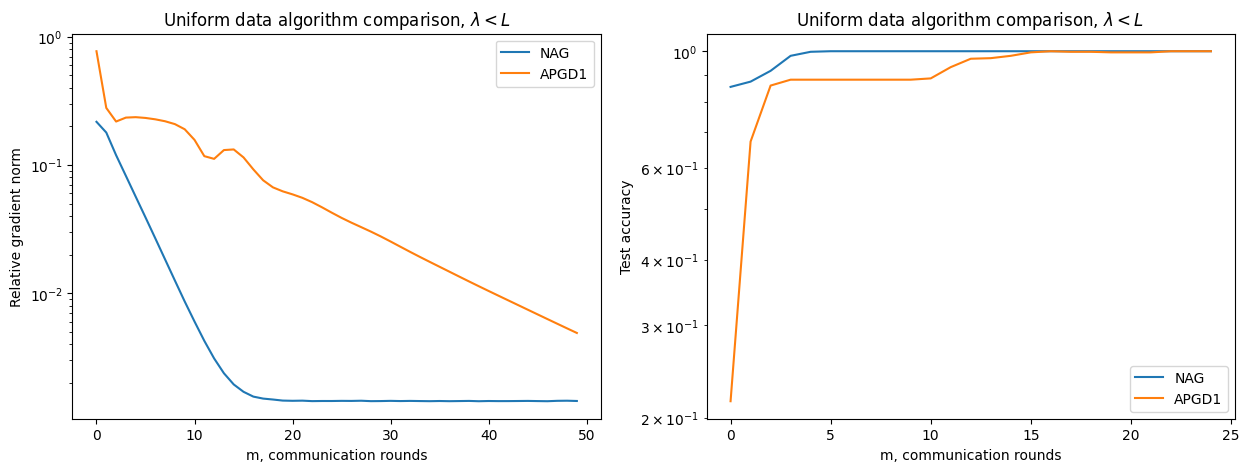

In [ ]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.semilogy(errors_NAG, label = 'NAG')
plt.semilogy(errors_1, label = 'APGD1')
plt.xlabel('m, communication rounds')
plt.ylabel('Relative gradient norm')
plt.legend()
plt.title('Uniform data algorithm comparison, $\lambda < L $')

plt.subplot(1, 2, 2)
plt.semilogy(accs_NAG[:25], label = 'NAG')
plt.semilogy(accs_1[:25], label = 'APGD1')
plt.xlabel('m, communication rounds')
plt.ylabel('Test accuracy')
plt.legend()
plt.title('Uniform data algorithm comparison, $\lambda < L $ ')
plt.show()

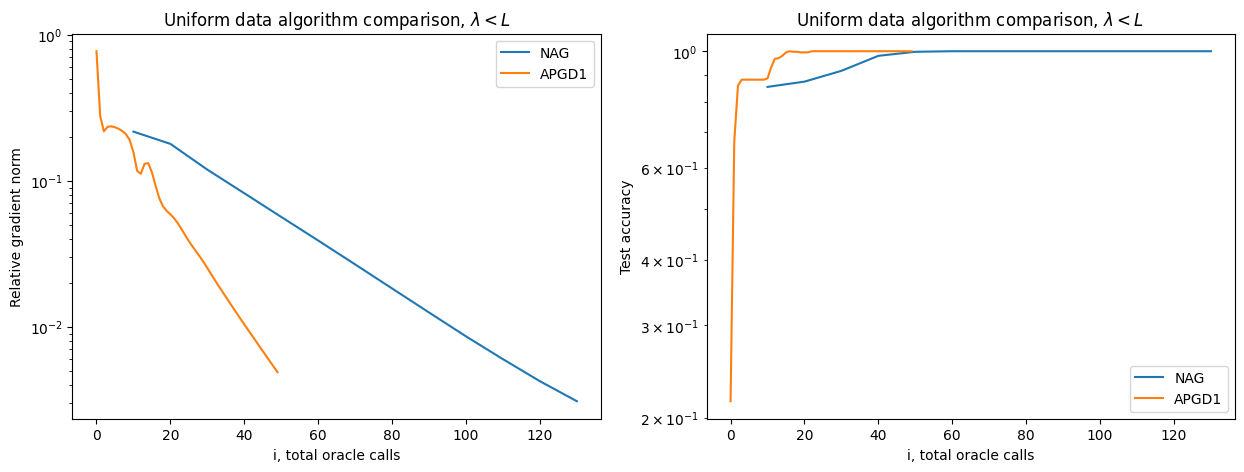

In [ ]:
num_iter= 13
num_oracles_NAG = list(accumulate(inner_const[:len(errors_NAG)]))[:num_iter]
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.semilogy(num_oracles_NAG, errors_NAG[:num_iter], label = 'NAG')
plt.semilogy(errors_1, label = 'APGD1')
plt.xlabel('i, total oracle calls')
plt.ylabel('Relative gradient norm')
plt.legend()
plt.title('Uniform data algorithm comparison, $\lambda < L $')

plt.subplot(1, 2, 2)
plt.semilogy(num_oracles_NAG, accs_NAG[:num_iter], label = 'NAG')
plt.semilogy(accs_1, label = 'APGD1')
plt.xlabel('i, total oracle calls')
plt.ylabel('Test accuracy')
plt.legend()
plt.title('Uniform data algorithm comparison, $\lambda < L $ ')
plt.show()

# $\lambda > L$

In [ ]:
key = jax.random.PRNGKey(42)
w_0 = jax.random.normal(key, [d])
lambd = 1.25*L
m = len(uni_loader)
inner_NAG = [int(np.sqrt(mu*(L + lambd)/lambd/(mu + lambd))*(1 + 4*k)) for k in range(1, 150)]
inner_const = [10  for k in range(1, 150)]

In [ ]:
w_NAG_close, errors_NAG_close, accs_NAG_close = APGD(f_value, Full, uni_loader, w_0, NAG, inner_NAG, lambd = 1.2*L, L = L, mu = mu, tol = 1e-4,  max_iter = 50, X_test = X_test, y_test = y_test)

100%|██████████| 50/50 [01:21<00:00,  1.64s/it]


In [ ]:
w_NAG_far, errors_NAG_far, accs_NAG_far = APGD(f_value, Full, uni_loader, w_0, NAG, inner_NAG, lambd = 2*L, L = L, mu = mu, tol = 1e-4,  max_iter = 50, X_test = X_test, y_test = y_test)

100%|██████████| 50/50 [01:25<00:00,  1.70s/it]


In [ ]:
w_0 = jax.random.normal(key, [d])
w_1_close, errors_1_close, accs_1_close= APGD(f_value, Full, uni_loader, w_0, None, None, lambd = 1.2*L, L = L, mu = mu, tol = 1e-4,  max_iter = 50, X_test = X_test, y_test = y_test )

100%|██████████| 50/50 [00:05<00:00,  8.42it/s]


In [ ]:
w_1_far, errors_1_far, accs_1_far= APGD(f_value, Full, uni_loader, w_0, None, None, lambd = 2*L, L = L, mu = mu, tol = 1e-4,  max_iter = 50, X_test = X_test, y_test = y_test )

100%|██████████| 50/50 [00:05<00:00,  8.47it/s]


Text(0.5, 1.0, 'Uniform data algorithm comparison, $\\lambda > L $')

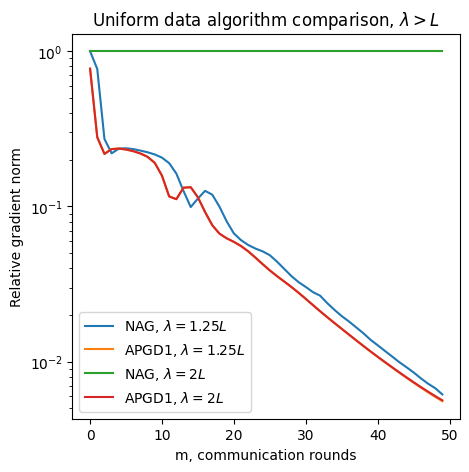

In [ ]:
plt.figure(figsize = (5, 5))

plt.semilogy(errors_NAG_close, label = 'NAG, $\lambda = 1.25L$')
plt.semilogy(errors_1_close, label = 'APGD1, $\lambda = 1.25L$')
plt.semilogy(errors_NAG_far, label = 'NAG, $\lambda = 2L$')
plt.semilogy(errors_1_far, label = 'APGD1, $\lambda = 2L$')
plt.xlabel('m, communication rounds')
plt.ylabel('Relative gradient norm')
plt.legend()
plt.title('Uniform data algorithm comparison, $\lambda > L $')

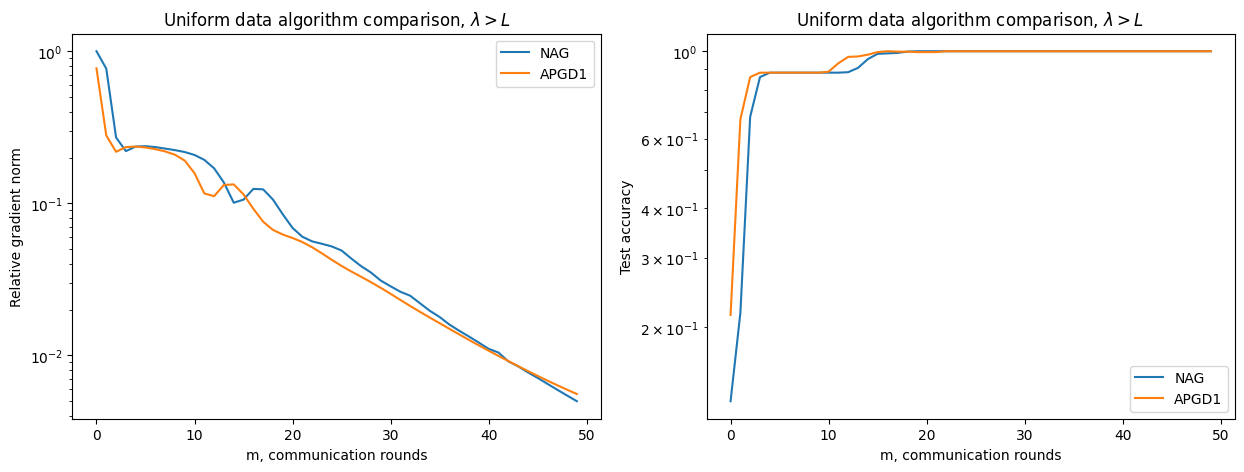

In [ ]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.semilogy(errors_NAG, label = 'NAG')
plt.semilogy(errors_1, label = 'APGD1')
plt.xlabel('m, communication rounds')
plt.ylabel('Relative gradient norm')
plt.legend()
plt.title('Uniform data algorithm comparison, $\lambda > L $')

plt.subplot(1, 2, 2)
plt.semilogy(accs_NAG, label = 'NAG')
plt.semilogy(accs_1, label = 'APGD1')
plt.xlabel('m, communication rounds')
plt.ylabel('Test accuracy')
plt.legend()
plt.title('Uniform data algorithm comparison, $\lambda > L $ ')
plt.show()

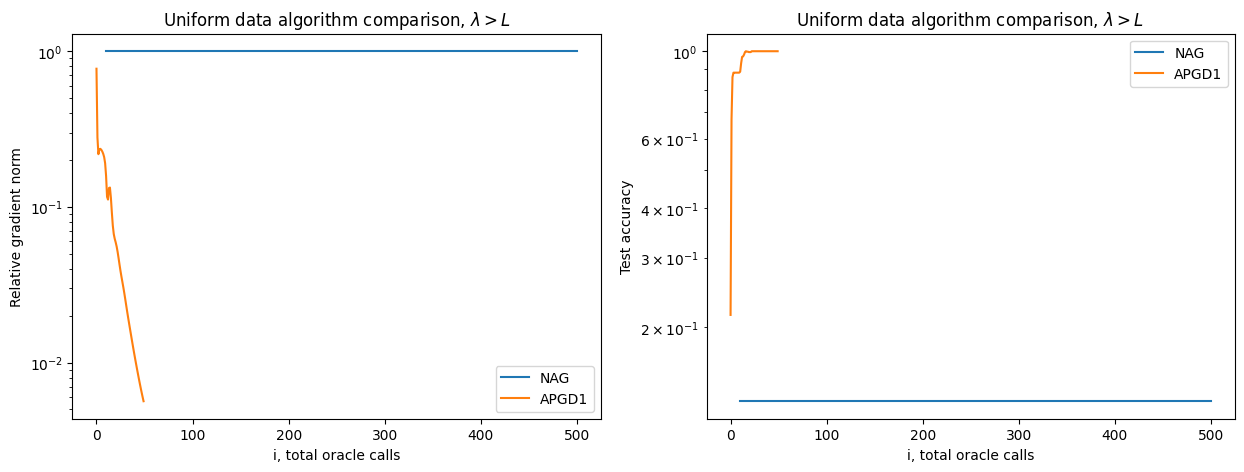

In [ ]:
num_oracles_NAG = list(accumulate(inner_const[:len(errors_NAG)]))
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.semilogy(num_oracles_NAG, errors_NAG, label = 'NAG')
plt.semilogy(errors_1, label = 'APGD1')
plt.xlabel('i, total oracle calls')
plt.ylabel('Relative gradient norm')
plt.legend()
plt.title('Uniform data algorithm comparison, $\lambda > L $')

plt.subplot(1, 2, 2)
plt.semilogy(num_oracles_NAG, accs_NAG, label = 'NAG')
plt.semilogy(accs_1, label = 'APGD1')
plt.xlabel('i, total oracle calls')
plt.ylabel('Test accuracy')
plt.legend()
plt.title('Uniform data algorithm comparison, $\lambda > L $ ')
plt.show()

# hetero $\lambda<L$

In [ ]:
key = jax.random.PRNGKey(42)
w_0 = jax.random.normal(key, [d])
lambd = 5*mu
m = len(prop_loader)
inner_NAG = [int(np.sqrt(mu*(L + lambd)/lambd/(mu + lambd))*(1 + k)) for k in range(1, 150)]
#inner_Kat = [int(2*m*(1+ np.sqrt(mu/lambd)*k))  for k in range(1, 150)]
inner_const = [10  for k in range(1, 150)]

In [ ]:
w_NAG_hetero, errors_NAG_hetero, accs_NAG_hetero = APGD(f_value, Full, prop_loader, w_0, NAG, inner_NAG, lambd = lambd, L = L, mu = mu, tol = 1e-4,  max_iter = 50, X_test = X_test, y_test = y_test )

100%|██████████| 50/50 [03:52<00:00,  4.66s/it]


In [ ]:
w_0 = jax.random.normal(key, [d])
w_1_hetero, errors_1_hetero, accs_1_hetero= APGD(f_value, Full, prop_loader, w_0, None, None, lambd = lambd, L = L, mu = mu, tol = 1e-4,  max_iter = 50, X_test = X_test, y_test = y_test )

100%|██████████| 50/50 [00:09<00:00,  5.03it/s]


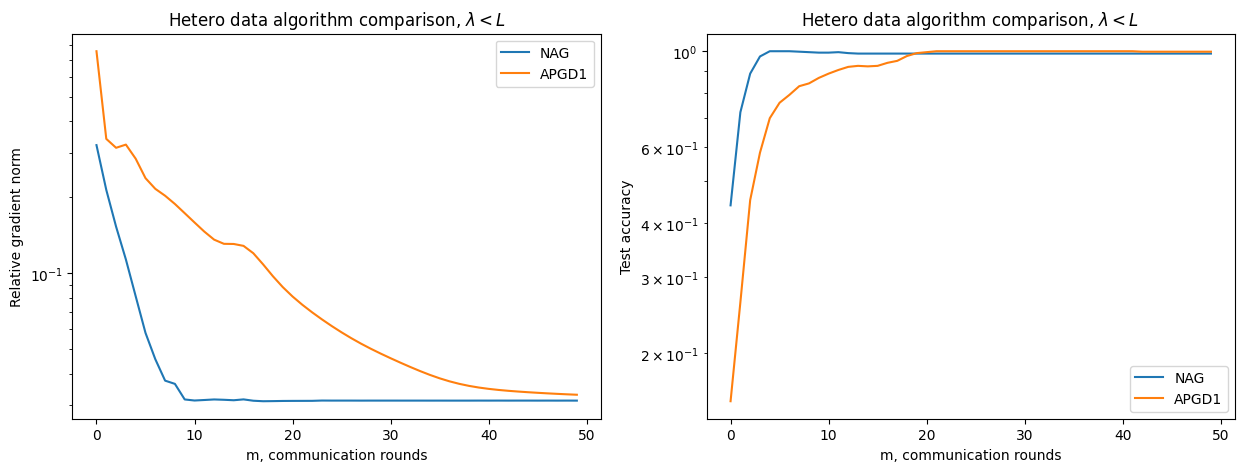

In [ ]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.semilogy(errors_NAG_hetero, label = 'NAG')
plt.semilogy(errors_1_hetero, label = 'APGD1')
plt.xlabel('m, communication rounds')
plt.ylabel('Relative gradient norm')
plt.legend()
plt.title('Hetero data algorithm comparison, $\lambda < L $')

plt.subplot(1, 2, 2)
plt.semilogy(accs_NAG_hetero, label = 'NAG')
plt.semilogy(accs_1_hetero, label = 'APGD1')
plt.xlabel('m, communication rounds')
plt.ylabel('Test accuracy')
plt.legend()
plt.title('Hetero data algorithm comparison, $\lambda < L $ ')
plt.show()

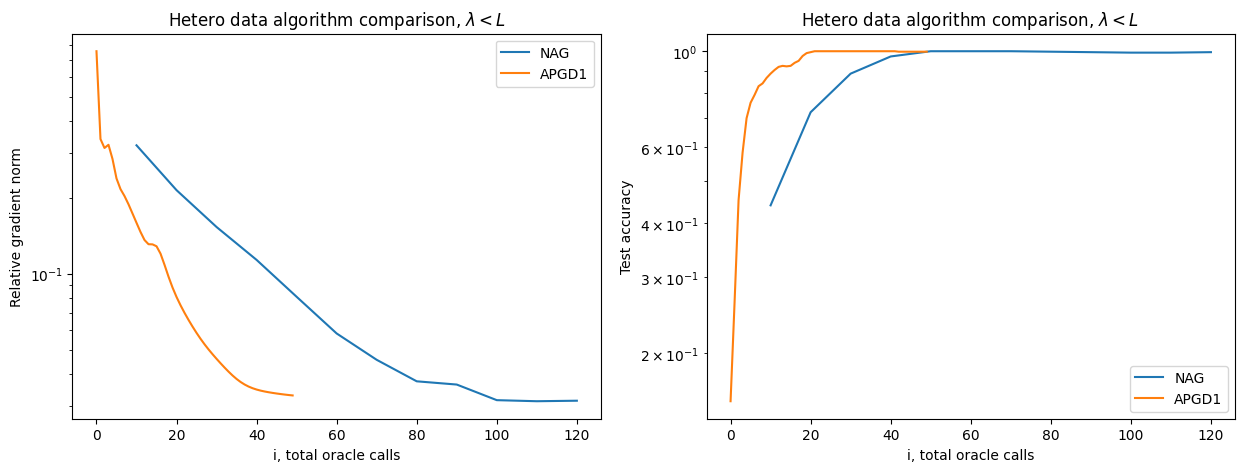

In [ ]:
num_oracles_NAG = list(accumulate(inner_const[:len(errors_NAG)]))[:12]
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.semilogy(num_oracles_NAG, errors_NAG_hetero[:12], label = 'NAG')
plt.semilogy(errors_1_hetero, label = 'APGD1')
plt.xlabel('i, total oracle calls')
plt.ylabel('Relative gradient norm')
plt.legend()
plt.title('Hetero data algorithm comparison, $\lambda < L $')

plt.subplot(1, 2, 2)
plt.semilogy(num_oracles_NAG, accs_NAG_hetero[:12], label = 'NAG')
plt.semilogy(accs_1_hetero, label = 'APGD1')
plt.xlabel('i, total oracle calls')
plt.ylabel('Test accuracy')
plt.legend()
plt.title('Hetero data algorithm comparison, $\lambda < L $ ')
plt.show()

Text(0.5, 1.0, 'Hetero power effect, $\\lambda < L $')

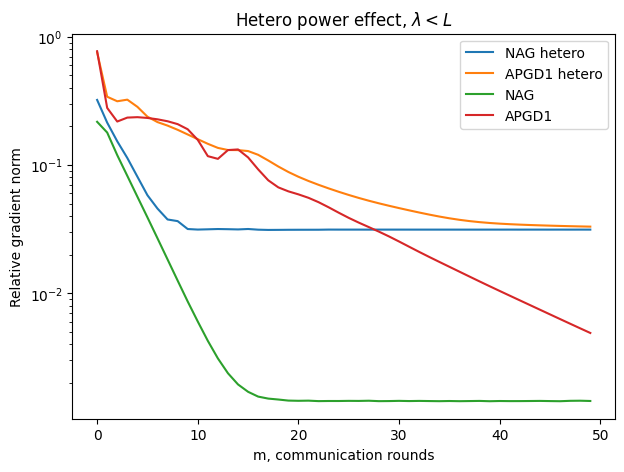

In [ ]:
plt.figure(figsize = (7, 5))

plt.semilogy(errors_NAG_hetero, label = 'NAG hetero')
plt.semilogy(errors_1_hetero, label = 'APGD1 hetero')
plt.semilogy(errors_NAG, label = 'NAG')
plt.semilogy(errors_1, label = 'APGD1')
plt.xlabel('m, communication rounds')
plt.ylabel('Relative gradient norm')
plt.legend()
plt.title('Hetero power effect, $\lambda < L $')